In [1]:
import json

import bz2
import regex
from tqdm import tqdm_notebook

from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with open('banki_responses.json', 'r') as thefile:
    for row in tqdm_notebook(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

# Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
len(df)

153499

In [8]:
df['city'].value_counts()[:10]

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: city, dtype: int64

In [9]:
len(df['text'][10])

1536

In [10]:
df['bank_name'].value_counts()[:10]

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: bank_name, dtype: int64

### 2. Постройте гистограмы длин слов в символах и в словах.
### *Прим.: Вероятно, имеется ввиду гистограммы тесктов в символах и в словах.*

### *В символах.*

(0, 8000)

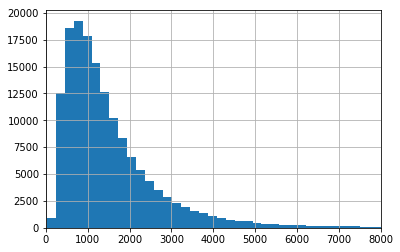

In [11]:
df['text'].apply(len).hist(bins=150)

plt.xlim(0, 8000)

### *В словах. Для начала проведем токенизацию.*

In [12]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df['text'] = df.text.apply(lambda x: x.lower())
df['words_only'] = df.text.apply(words_only)

In [13]:
df['tokenized_sents'] = df.words_only.apply(lambda x: x.split(' '))

In [14]:
df['tokenized_sents_len'] = df['tokenized_sents'].apply(len)

(0, 1000)

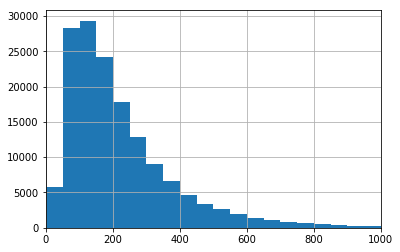

In [15]:
df['tokenized_sents_len'].hist(bins=100)

plt.xlim(0, 1000)

### И в том и в другом случае мы получаем эксп. распределение.

### 3. Найдите 10 самых частых:
        
* слов
* слов без стоп-слов
* лемм 
* существительных

In [16]:
from collections import Counter

In [17]:
def counter(how):
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens = []
    for index, row in tqdm_notebook(df.iterrows(), total = len(df)):
        tokens = row[how].split()
        cnt.update(tokens)
        n_types.append(len(cnt))
        n_tokens.append(sum(cnt.values()))
    for i in cnt.most_common(10):
        print(i)

In [18]:
counter('words_only')


('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


### Как видно, основные слова это предлоги и слово "банк", так как тексты о банках. Избавимся от слоп-слов.

In [19]:
from nltk.corpus import stopwords
sw = stopwords.words('russian') + ['т', 'д', 'это']

In [20]:
def  remove_stopwords(text, mystopwords = sw):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [21]:
df['words_only_without_sw']= df['words_only'].apply(remove_stopwords) 

In [22]:
counter('words_only_without_sw')


('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


### Теперь лемматизация

In [23]:
from pymorphy2 import MorphAnalyzer

pm2 = MorphAnalyzer()


def lemmatize(text, mystem=pm2):
    try:
        return ' '.join([pm2.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "

### Возьмем первые 1000 текстов, так как текстов слишком много.

In [24]:
df['lemmas'] = df['words_only_without_sw'][:1000].apply(lemmatize) 

In [25]:
df['lemmas'] = df['lemmas'].fillna('')

In [26]:
 counter('lemmas')


('банка', 2366)
('карта', 1801)
('банк', 1713)
('год', 1068)
('кредит', 937)
('мой', 895)
('который', 865)
('деньга', 853)
('вклад', 817)
('день', 811)


### Как видно, есть проблема того, что отличает леммы "банка" и "банк", хотя это одно и тоже слово в нашем контексте.

### 4. Постройте кривые Ципфа и Хипса

In [ ]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm_notebook(df.iterrows(), total = len(df)):
    tokens = row['words_only'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))
for i in cnt.most_common(10):
    print(i)

### Кривая Ципфа.

In [ ]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Кривая Хипса

ValueError: x and y must have same first dimension, but have shapes (265248,) and (153499,)

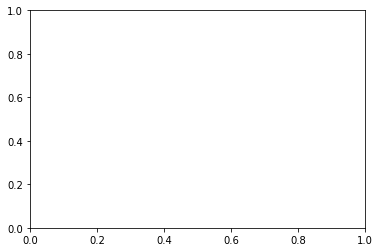

In [29]:
fig, ax = plt.subplots()
ax.plot(n_tokens[0], n_types)
plt.show()

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])
